In this notebook, we will preprocess the given file for the task and then run the autoencoder to perform dimensionality reduction.

## Look into the dataset

Loading the given data file and saving it after extracting useful data.

In [1]:
from csv import reader,writer

#Create new data file to store processed data for training
with open('extractJets.csv', 'a', newline='') as f_object: 
    writer(f_object).writerow(["pt","eta","phi","m"])

with open('./data.csv', 'r') as read_obj:
    csv_reader = reader(read_obj)
#   Read data on row by row basis
    for row in csv_reader:
        for i in range(4,len(row),4):
#           Check if it is a jet particle. If yes, then add to dataset
            if('j' in row[i]):
                row[i], *_ = row[i].partition(';')
                with open('extractJets.csv', 'a', newline='') as f_object: 
                    writer_object = writer(f_object) 
                    writer_object.writerow(row[i-3:i+1]) 
                    f_object.close()

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Path to parsed dataset
data_path = './extractJets.csv'

# Load the data into datframe
unprocessed_df = pd.read_csv(data_path)

# Normalise the data
scaler = preprocessing.MinMaxScaler()
names = unprocessed_df.columns
d = scaler.fit_transform(unprocessed_df)
df = pd.DataFrame(d, columns=names)

# Split the data into train and test sets
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# To get an idea of the order of magnitude we are going to see in the plots we show the first elements 
# in the samples:
print('Training sample:')
print(train.head())

print('\n')

print('Testing sample:')
print(test.head())

print('\n')

print('The number of entries in the training data:', len(train))
print('The number of entries in the validation data:', len(test))
# Confirming no loss of data during the split
print('Total data is: ', len(train) + len(test))

Training sample:
             pt       eta       phi         m
16028  0.067739  0.093866  0.410113  0.185391
4395   0.133575  0.048781  0.265619  0.017063
13101  0.185925  0.162865  0.671072  0.233792
2578   0.133303  0.177378  0.617986  0.644592
13724  0.099197  0.188893  0.559642  0.096026


Testing sample:
             pt       eta       phi         m
5426   0.119523  0.166930  0.611878  0.340523
8583   0.039201  0.017252  0.309096  0.835562
12309  0.013649  0.024880  0.564555  0.435482
3599   0.188569  0.366296  0.463032  0.966026
1247   0.209072  0.157122  0.332110  0.853213


The number of entries in the training data: 13167
The number of entries in the validation data: 3292
Total data is:  16459


Now we plot the data using the matplotlib library. The units reflect the normalization, but it's the shape that we care about. 

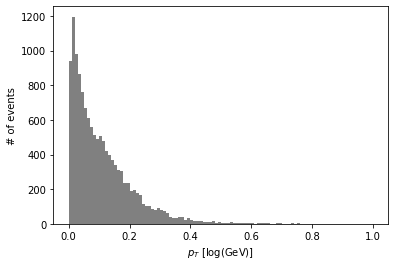

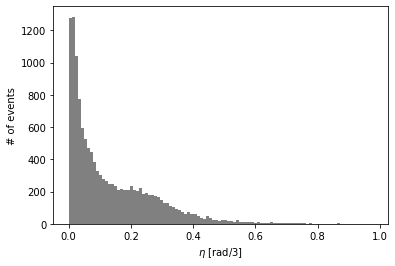

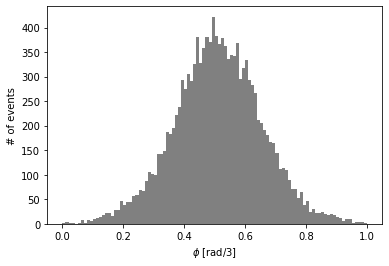

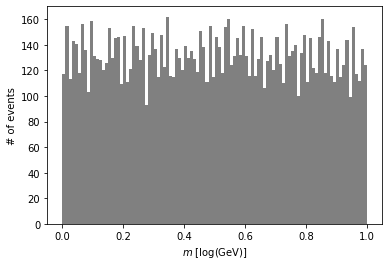

In [3]:
import matplotlib.pyplot as plt

unit_list = ['[log(GeV)]', '[rad/3]', '[rad/3]', '[log(GeV)]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$m$']

branches=["pt","eta","phi","m"]

n_bins = 100

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of events')
    #plt.savefig("fourmomentum_"+branches[kk],dpi=300)
    plt.show()

## Setting up the network

### Preparing the data

Adding the two datasets as TensorDatasets to PyTorch (also loading all other classes we'll need later)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

train_x = train
test_x = test
train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

We now set things up to load the data, and I have modified the batch size to achieve better performance.

In [5]:
bs = 64

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

### Preparing the network

Here we have an example network. Details aren't too important, as long as they match what was already trained for us...in this case we have a LeakyReLU, tanh activation function, and a number of layers that goes from 4 to 200 to 20 to 3 (number of features in the hidden layer that we pick for testing compression) and then back all the way to 4. 

In [6]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

We now have to pick a loss function - MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize. 

In [7]:
from fastai.metrics import mse

loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
#true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)
#was: learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

## Alternative 1: Running a pre-trained network

Now we load the pre-trained network. 

In [8]:
# learn.load("4D_TLA_leading")

Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well...if it has not trained as well (note the pesky 0-mass peak above...) then it's going to be a bit higher.

In [9]:
learn.validate()

(#1) [0.1381639540195465]

## Alternative 2: Training a new network

Instead of using a pre-trained network, an alternative is to train a new network and use that instead. 

First, we want to find the best learning rate. The learning rate is a hyper-paramater that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rates is then either:
- one tenth of the minimum before the divergence
- when the slope is the steepest

Learning rate with the minimum loss: 0.002290867641568184
Learning rate with the steepest gradient: 0.0003981071640737355


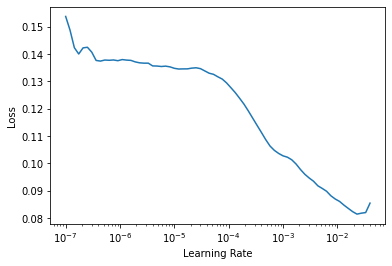

In [10]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

Now we want to run the training!

User-chosen variables:
- n_epoch: The number of epochs, i.e how many times the to run through all of the training data once (i.e the 1266046 entries, see cell 2)
- lr: The learning rate. Either choose lr_min, lr_steep from above or set your own.


In [11]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(n_epoch=100, lr_max=lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 0.014552670530974865, 0.009458094835281372, '00:01']
[0, 0.014552670530974865, 0.009458094835281372, '00:01']
[1, 0.0016025796066969633, 0.001056070439517498, '00:01']
[1, 0.0016025796066969633, 0.001056070439517498, '00:01']
[2, 0.001001488883048296, 0.0009725525742396712, '00:01']
[2, 0.001001488883048296, 0.0009725525742396712, '00:01']
[3, 0.0010003655916079879, 0.0010681188432499766, '00:01']
[3, 0.0010003655916079879, 0.0010681188432499766, '00:01']
[4, 0.001037830370478332, 0.0008955596713349223, '00:01']
[4, 0.001037830370478332, 0.0008955596713349223, '00:01']
[5, 0.0009532425319775939, 0.0008032954065129161, '00:01']
[5, 0.0009532425319775939, 0.0008032954065129161, '00:01']
[6, 0.0006464013713411987, 0.00056809326633811, '00:01']
[6, 0.0006464013713411987, 0.00056809326633811, '00:01']
[7, 0.00047443341463804245, 0.0004884374211542308, '00:01']
[7, 0.00047443341463804245, 0.0004884374211542308, '00:01']
[8, 0.00039470187039114535, 0.0004840762121602893, '00:01']
[8, 0.00

[69, 4.090243237442337e-06, 3.899134298990248e-06, '00:01']
[69, 4.090243237442337e-06, 3.899134298990248e-06, '00:01']
[70, 3.1257927730621304e-06, 2.3267275537364185e-06, '00:01']
[70, 3.1257927730621304e-06, 2.3267275537364185e-06, '00:01']
[71, 2.2924568838789128e-06, 3.4298354876227677e-06, '00:01']
[71, 2.2924568838789128e-06, 3.4298354876227677e-06, '00:01']
[72, 2.379893658144283e-06, 3.1717866022518137e-06, '00:01']
[72, 2.379893658144283e-06, 3.1717866022518137e-06, '00:01']
[73, 2.0377838154672645e-06, 1.9236799744248856e-06, '00:01']
[73, 2.0377838154672645e-06, 1.9236799744248856e-06, '00:01']
[74, 1.5616927839801065e-06, 2.4292537545989035e-06, '00:01']
[74, 1.5616927839801065e-06, 2.4292537545989035e-06, '00:01']
[75, 1.8686356497710221e-06, 1.9386218355066376e-06, '00:01']
[75, 1.8686356497710221e-06, 1.9386218355066376e-06, '00:01']
[76, 1.6737074020056752e-06, 2.2460387754108524e-06, '00:01']
[76, 1.6737074020056752e-06, 2.2460387754108524e-06, '00:01']
[77, 1.3308230

Then we plot the loss as a function of batches and epochs to check if we reach a plateau.

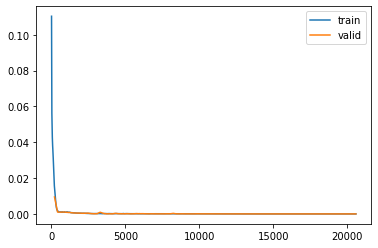

In [12]:
recorder.plot_loss()

Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well...if it has not trained as well (note the pesky 0-mass peak above...) then it's going to be a bit higher.

In [13]:
learn.validate()

(#1) [7.584371246593946e-07]

Let's plot all of this, with ratios (thanks to code by Erik Wallin)

## Plotting the outputs of the network

Lazy-save of our output files (they'll also be on screen)

In [14]:
import os
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

A function in case we want to un-normalize and get back to physical quantities...

In [15]:
def custom_unnormalize(df):
    df['eta'] = df['eta'] * 5
    df['phi'] = df['phi'] * 3
    #df['E'] = 10**df['E']
    df['m'] = 10**df['m']
    df['pt'] = 10**(df['pt'])
    return df

Make the histograms from the dataset...

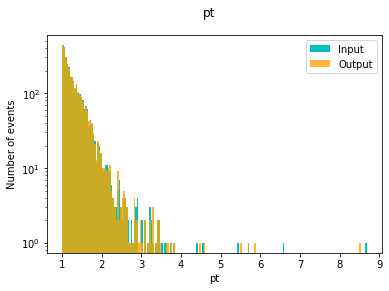

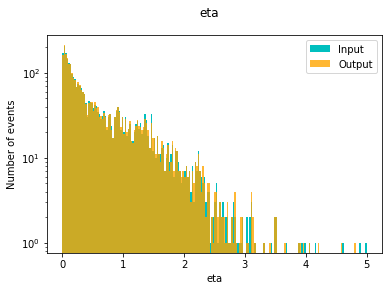

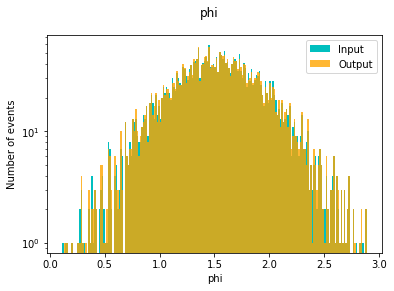

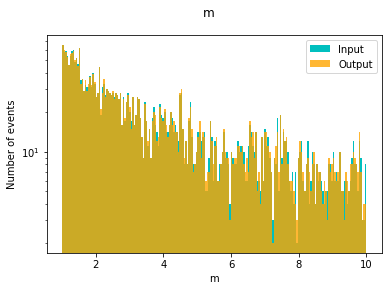

In [16]:
import numpy as np

plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

save = False # Option to save figure

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float)
#data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float).double()
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test.columns)
pred_df = pd.DataFrame(pred, columns=test.columns)

unnormalized_data_df = custom_unnormalize(data_df)
unnormalized_pred_df = custom_unnormalize(pred_df)    
    
alph = 0.8
n_bins = 200
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test.columns[kk])
    plt.xlabel(test.columns[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test.columns[kk]+'.png'))
    plt.legend()

In [17]:
def getRatio(bin1,bin2):
    bins = []
    for b1,b2 in zip(bin1,bin2):
        if b1==0 and b2==0:
            bins.append(0.)
        elif b2==0:
            bins.append(None)
        else:
            bins.append((float(b2)-float(b1))/b1)
    return bins   

rat = getRatio(n_hist_data,n_hist_pred)
#print(rat)

Let's check how much percentage difference exists in our input and output.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


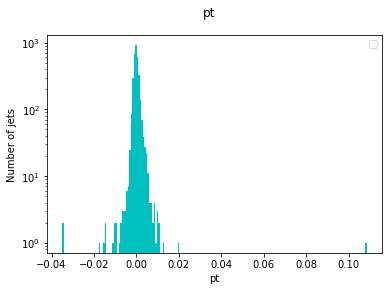

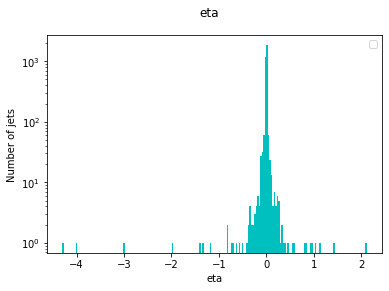

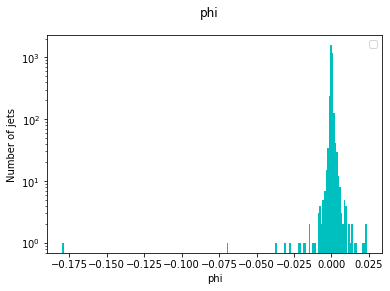

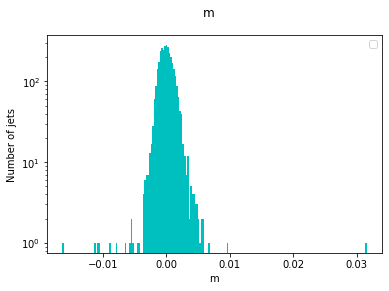

In [56]:
variable_list = [r'$p_Tin - p_Tout$', r'$\eta$', r'$\phi$', r'$E$']

idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float)
#data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float).double()
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test.columns)
pred_df = pd.DataFrame(pred, columns=test.columns)

unnormalized_data_df = custom_unnormalize(data_df)
unnormalized_pred_df = custom_unnormalize(pred_df)    

for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(np.divide((data[:, kk]-pred[:, kk]),data[:, kk]), color=colors[1], alpha=1, bins=n_bins)
    plt.suptitle(test.columns[kk])
    plt.xlabel(test.columns[kk])
    plt.ylabel('Number of jets')
    # ms.sciy()
    plt.yscale('log')
    plt.legend()

Let's compare the 3D plots of data before and after compression

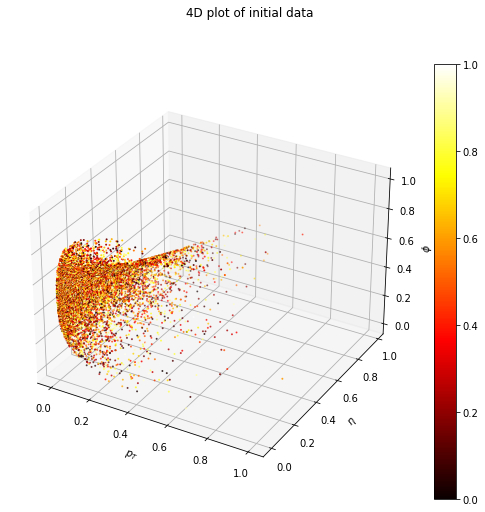

Text(0.5, 0, '$z_3$')

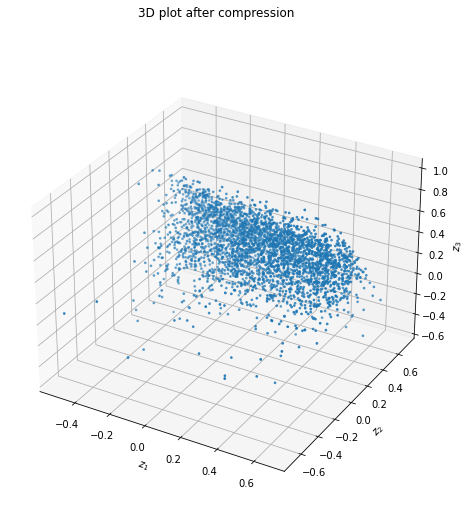

In [34]:
from mpl_toolkits.mplot3d import Axes3D

# Plot 4d data before compression
fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111, projection='3d')
w = train['pt']
x = train['eta']
y = train['phi']
z = train['m']
img = ax.scatter(w, x, y, c=z, s=1)
plt.suptitle('4D plot of initial data')
ax.set_xlabel(r'$p_T$')
ax.set_ylabel(r'$\eta$')
ax.set_zlabel(r'$\phi$')
fig.colorbar(img)
plt.show()

# Plot 3d compressed data
idxs = (0, 10000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
latent = model.encode(data.float()).detach().numpy()
fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latent[:, 0], latent[:, 1], latent[:, 2], s=3)
plt.suptitle('3D plot after compression')
ax.set_xlabel(r'$z_1$')
ax.set_ylabel(r'$z_2$')
ax.set_zlabel(r'$z_3$')